In [1]:
from george.modeling import Model

class Model(Model):
    parameter_names = ("amp", "location", "log_sigma2")

    def get_value(self, t):
        return self.amp * np.exp(-0.5*(t.flatten()-self.location)**2 * np.exp(-self.log_sigma2))

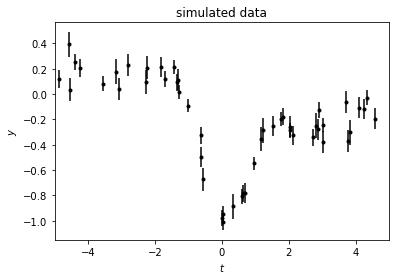

In [2]:
import numpy as np
import matplotlib.pyplot as pl
from george import kernels
import george

np.random.seed(1234)

def generate_data(params, N, rng=(-5, 5)):
    gp = george.GP(0.1 * kernels.ExpSquaredKernel(3.3))
    t = rng[0] + np.diff(rng) * np.sort(np.random.rand(N))
    y = gp.sample(t)
    y += Model(**params).get_value(t)
    yerr = 0.05 + 0.05 * np.random.rand(N)
    y += yerr * np.random.randn(N)
    return t, y, yerr

truth = dict(amp=-1.0, location=0.1, log_sigma2=np.log(0.4))
t, y, yerr = generate_data(truth, 50)

pl.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
pl.ylabel(r"$y$")
pl.xlabel(r"$t$")
pl.xlim(-5, 5)
pl.title("simulated data");

In [3]:
class PolynomialModel(Model):
    parameter_names = ("m", "b", "amp", "location", "log_sigma2")

    def get_value(self, t):
        t = t.flatten()
        return (t * self.m + self.b +
                self.amp * np.exp(-0.5*(t-self.location)**2*np.exp(-self.log_sigma2)))

In [4]:
model = george.GP(mean=PolynomialModel(m=0, b=0, amp=-1, location=0.1, log_sigma2=np.log(0.4)))
model.compute(t, yerr)

def lnprob(p):
    model.set_parameter_vector(p)
    return model.log_likelihood(y, quiet=True) + model.log_prior()

In [5]:
import emcee

initial = model.get_parameter_vector()
ndim, nwalkers = len(initial), 32
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, 500)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 1000);

Running burn-in...
Running production...


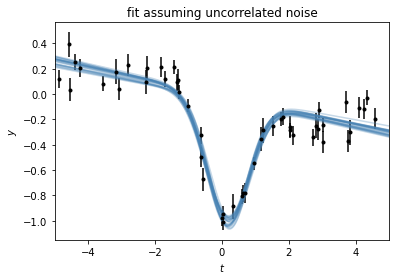

In [6]:
# Plot the data.
pl.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)

# The positions where the prediction should be computed.
x = np.linspace(-5, 5, 500)

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    model.set_parameter_vector(s)
    pl.plot(x, model.mean.get_value(x), color="#4682b4", alpha=0.3)

pl.ylabel(r"$y$")
pl.xlabel(r"$t$")
pl.xlim(-5, 5)
pl.title("fit assuming uncorrelated noise");

[2 3 4]


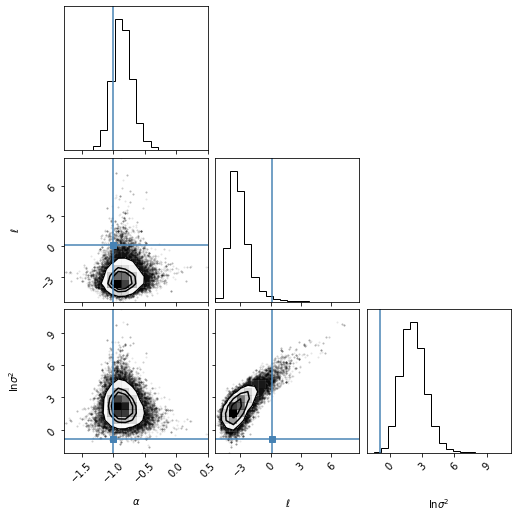

In [12]:
import corner

tri_cols = ["amp", "location", "log_sigma2"]
tri_labels = [r"$\alpha$", r"$\ell$", r"$\ln\sigma^2$"]
tri_truths = [truth[k] for k in tri_cols]
tri_range = [(-2, -0.01), (-3, -0.5), (-1, 1)]
names = model.get_parameter_names()
inds = np.array([names.index("mean:"+k) for k in tri_cols])
print(inds)
corner.corner(sampler.flatchain[:, inds], truths=tri_truths, labels=tri_labels);

In [8]:
kwargs = dict(**truth)
kwargs["bounds"] = dict(location=(-2, 2))
mean_model = Model(**kwargs)
gp = george.GP(np.var(y) * kernels.Matern32Kernel(10.0), mean=mean_model)
gp.compute(t, yerr)

def lnprob2(p):
    gp.set_parameter_vector(p)
    return gp.log_likelihood(y, quiet=True) + gp.log_prior()

In [9]:
initial = gp.get_parameter_vector()
ndim, nwalkers = len(initial), 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2)

print("Running first burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 2000)

print("Running second burn-in...")
p0 = p0[np.argmax(lp)] + 1e-8 * np.random.randn(nwalkers, ndim)
sampler.reset()
p0, _, _ = sampler.run_mcmc(p0, 2000)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 2000);

Running first burn-in...
Running second burn-in...
Running production...


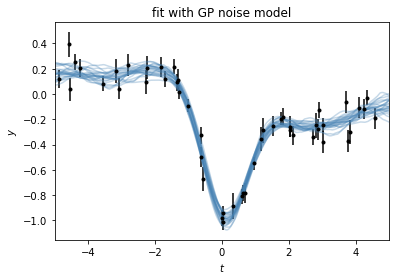

In [10]:
# Plot the data.
pl.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)

# The positions where the prediction should be computed.
x = np.linspace(-5, 5, 500)

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    gp.set_parameter_vector(s)
    mu = gp.sample_conditional(y, x)
    pl.plot(x, mu, color="#4682b4", alpha=0.3)

pl.ylabel(r"$y$")
pl.xlabel(r"$t$")
pl.xlim(-5, 5)
pl.title("fit with GP noise model");

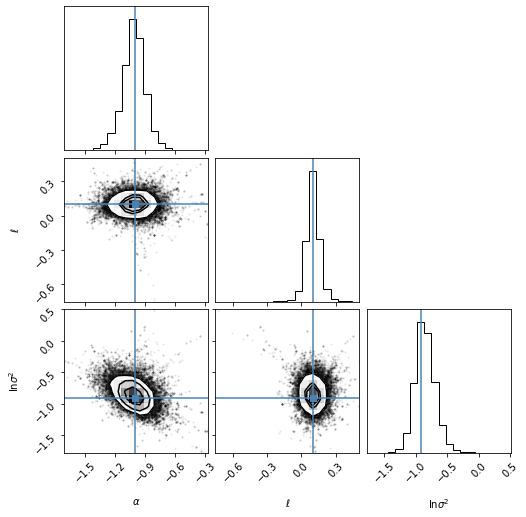

In [11]:
names = gp.get_parameter_names()
inds = np.array([names.index("mean:"+k) for k in tri_cols])
corner.corner(sampler.flatchain[:, inds], truths=tri_truths, labels=tri_labels);